In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from ctapipe_io_lst import LSTEventSource
from ctapipe.image.extractor import LocalPeakWindowSum
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

from traitlets.config.loader import Config 
from lstchain.calib.camera.r0 import LSTR0Corrections

from lstchain.calib.camera.time_correction_calculate import TimeCorrectionCalculate 
from lstchain.calib.camera.pulse_time_correction import PulseTimeCorrection

plt.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# This is notebook to low level calibration R0->R1 
Fill the R1 container ```event.r1.tel[0].waveform```.

Following function exist:
1. to subtraction pedestal ```subtract_pedestal(event)```
2. to dt correction ```time_lapse_corr(event)```
3. to interpolate spikes ```interpolate_spikes(event)```

or you can call method ```calibrate(event)```, then baseline value will be around 0. This is the preferred way to do low level corrections.

To subtraction pedestal you need pedestal file from cta-lstchain-extra or you can create pedestal file yourself using scirpt ```create_pedestal_file.py```

In ```config``` you can set how many samples in waveform keep to R1 container (first three and last sample in waveform are noisy)  

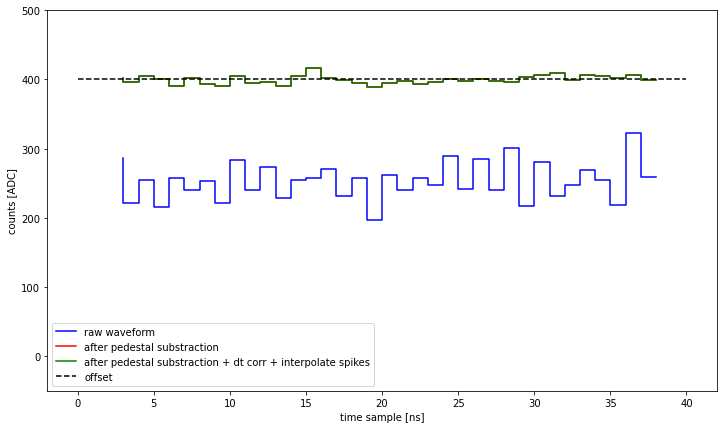

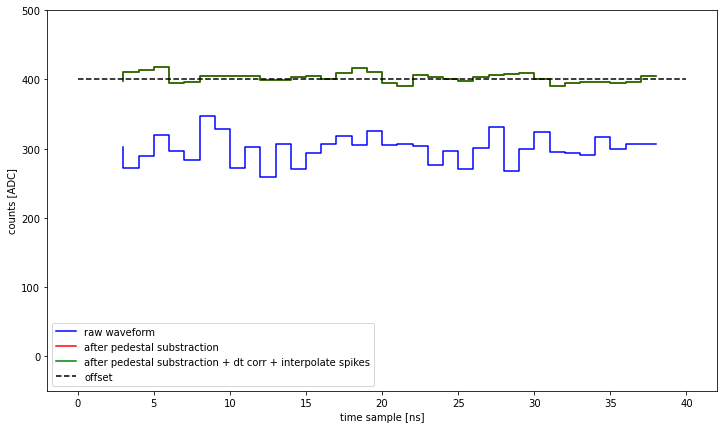

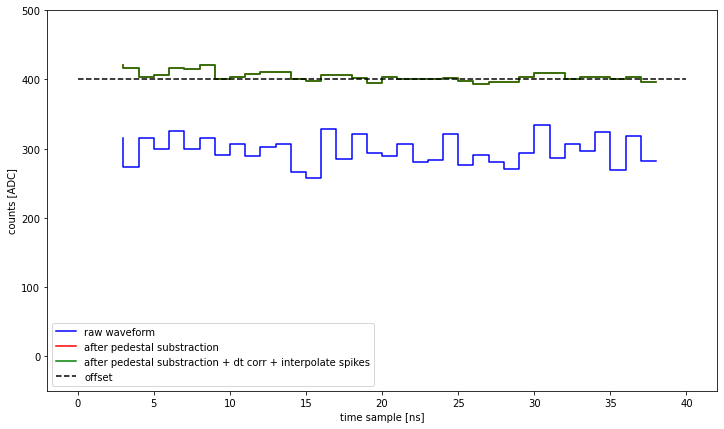

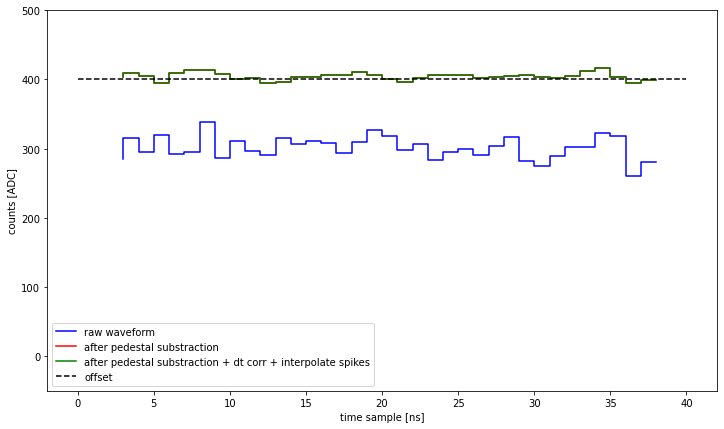

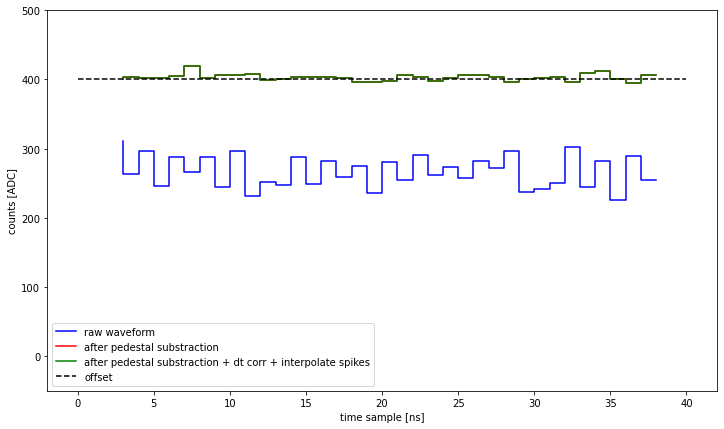

In [39]:
# Give path to real LST data
# We have to use LSTEventSource: LST-1.1.Run00xxx.xxx.fits.fz
# because for dt correction and interpolate spikes events must be in turn (event_id = 0,1,2, ...)
reader = LSTEventSource(input_url="../data/LST-1.1.Run01599.0001.fits.fz",
                        max_events=5)

# Otherwise, you can give your own input file
#reader = LSTEventSource(input_url= )#Any .fits.fz you might have

offset_value = 400
# Give path to pedestal file and set offset to baseline
# Assuming that you are running the Notebook from ~/cta-lstchain/notebooks
tel_id = 1
config = Config({
    "LSTR0Corrections": {
        "pedestal_path": "../data/drs4_pedestal.Run1599.0000.fits",
        "offset":  offset_value,
        "tel_id": tel_id, 
        "r1_sample_start": None,
        "r1_sample_end": None
    }
})
# Give path to pedestal file
lst_r0 = LSTR0Corrections(config=config)

t = np.linspace(3, 38, 36)

for ev in reader:
    plt.figure(figsize=(12, 7))
    plt.step(t,  ev.r0.tel[tel_id].waveform[0, 7, 3:39], color="blue", label="raw waveform")
    
    lst_r0.subtract_pedestal(ev, tel_id=tel_id)
    
    plt.step(t,  ev.r1.tel[tel_id].waveform[0, 7, 3:39], color="red", label="after pedestal substraction ")
    
    lst_r0.time_lapse_corr(ev, tel_id=tel_id)
    lst_r0.interpolate_spikes(ev, tel_id=tel_id)
    
    plt.step(t,  ev.r1.tel[tel_id].waveform[0, 7, 3:39], color="green", label="after pedestal substraction + dt corr + interpolate spikes")
    plt.plot([0, 40], [offset_value, offset_value], 'k--', label="offset")
    plt.xlabel("time sample [ns]")
    plt.ylabel("counts [ADC]")
    plt.legend()
    plt.ylim([-50, 500])
    plt.show()

# Call ```calibrate``` method

This is the preferred way to do low level corrections.

53001


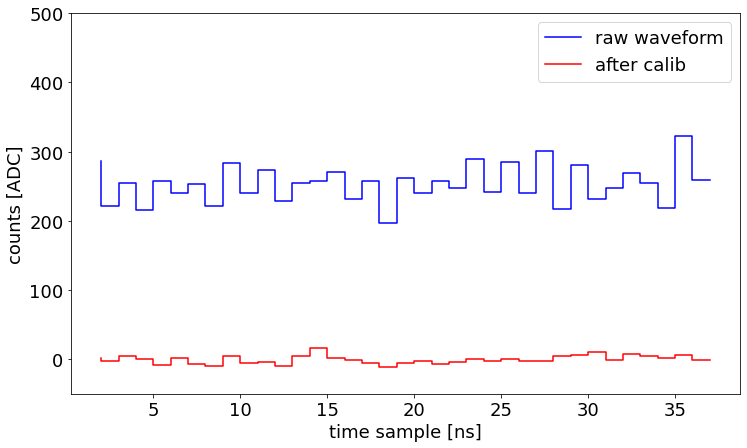

53002


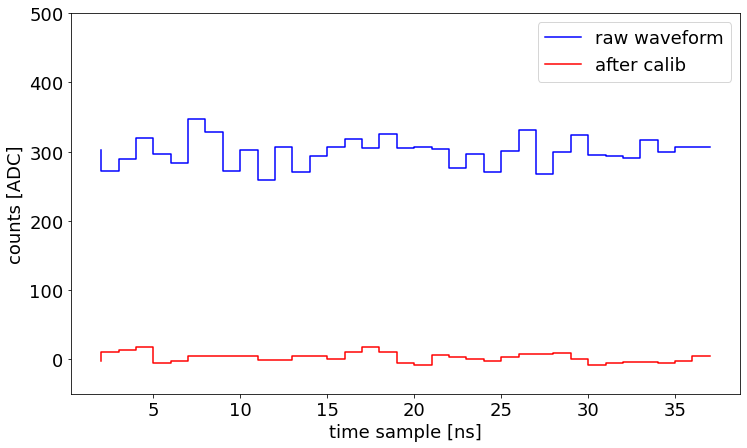

53003


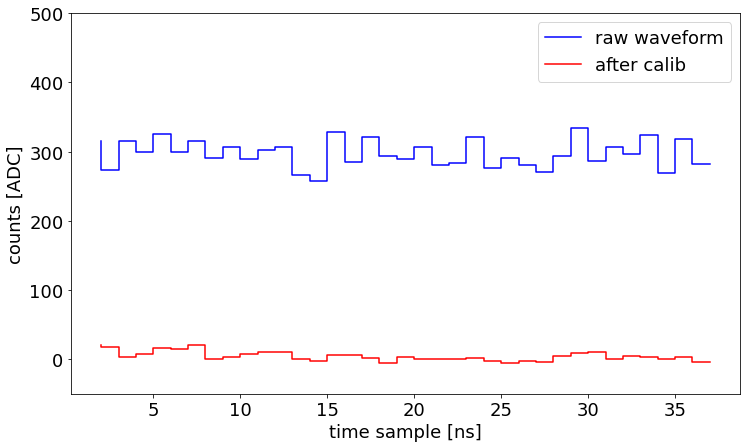

53004


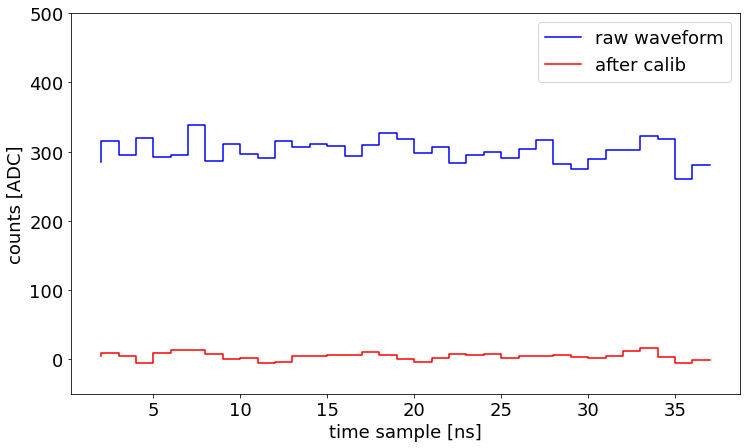

53005


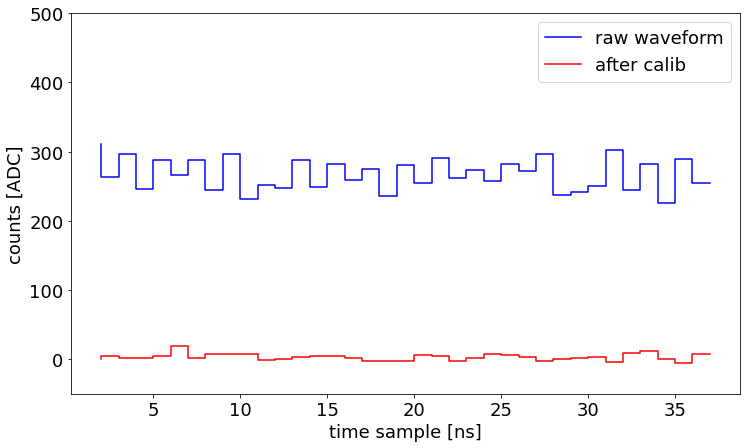

In [4]:
# Give path to real LST data
reader = LSTEventSource(
    input_url="../data/LST-1.1.Run01599.0001.fits.fz",
    max_events=5)

# Again, you can give your own input file
#reader = LSTEventSource(input_url= )#Any .fits.fz you might have

tel_id = 1
# Give path to pedestal file 
config = Config({
    "LSTR0Corrections": {
        "pedestal_path": "../data/drs4_pedestal.Run1599.0000.fits",
    }
})

lst_r0 = LSTR0Corrections(config=config)

t = np.linspace(2, 37, 36)

for ev in reader:
    print(ev.index.event_id)
    plt.figure(figsize=(12, 7))
    plt.step(t,  ev.r0.tel[tel_id].waveform[0, 7, 3:39], color="blue", label="raw waveform")
    
    lst_r0.calibrate(ev)

    plt.step(t,  ev.r1.tel[tel_id].waveform[0, 7, :], color="red", label="after calib")
    
    plt.xlabel("time sample [ns]")
    plt.ylabel("counts [ADC]")
    plt.legend()
    plt.ylim([-50, 500])
    plt.show()

## Time calibration constants calculation

Do not run it on the demonstration. Run it only if you want to recalculate the file.

In [ ]:
reader = LSTEventSource(
    input_url="../data/LST-1.1.Run01625.0001.fits.fz",
    max_events=20000)

charge_config = Config({
    "LocalPeakWindowSum":{
        "window_shift":4,
        "window_width":8
    }
})

# Here you have to give path, where you want save calibration file
timeCorr = TimeCorrectionCalculate(calib_file_path='../data/time_calib_run1625.h5',
                                   config=charge_config, 
                                   subarray=reader.subarray)
tel_id = 1
config = Config({
        "LSTR0Corrections": {
            "pedestal_path": None, # if baseline correction was done in EVB
            "tel_id": tel_id,
            "r1_sample_start":3,
            "r1_sample_end":39
        }
})

lst_r0 = LSTR0Corrections(config=config)

for i, ev in enumerate(reader):
    if ev.index.event_id%5000 == 0:
        print(ev.index.event_id)
        
    lst_r0.calibrate(ev)                  # Cut in signal to avoid cosmic events      
    if ev.r0.tel[tel_id].trigger_type == 1 and np.mean(ev.r1.tel[tel_id].waveform[:, :, :]) > 100:
        timeCorr.calibrate_peak_time(ev)

In [ ]:
timeCorr.finalize()

## Apply time correction to camera calibration data

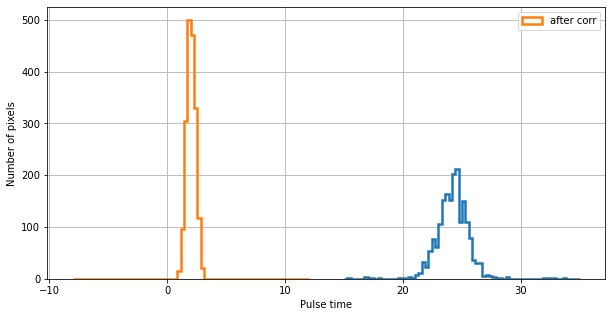

std before correction 1.38
std after correction 0.38


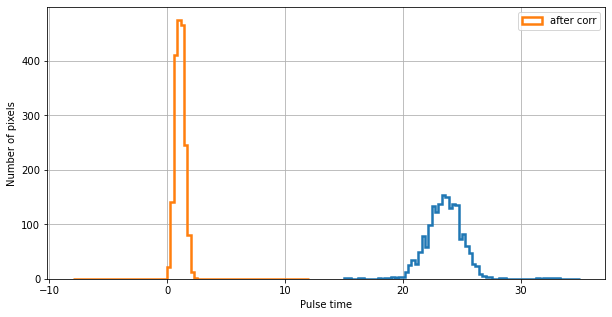

std before correction 1.58
std after correction 0.38


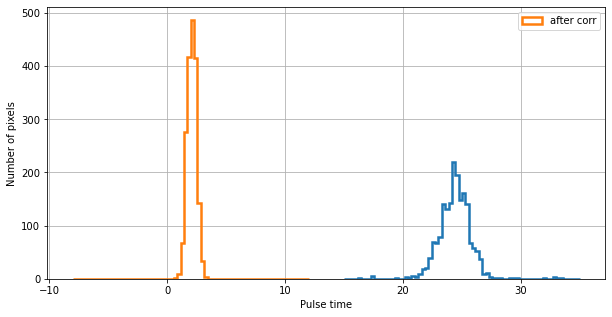

std before correction 1.36
std after correction 0.38


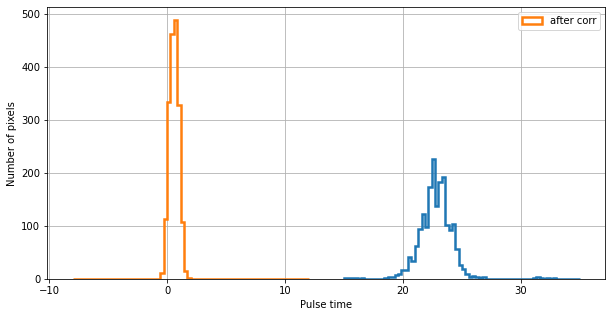

std before correction 1.39
std after correction 0.38


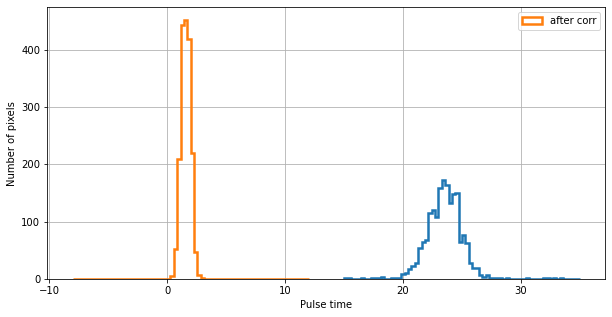

std before correction 1.51
std after correction 0.39


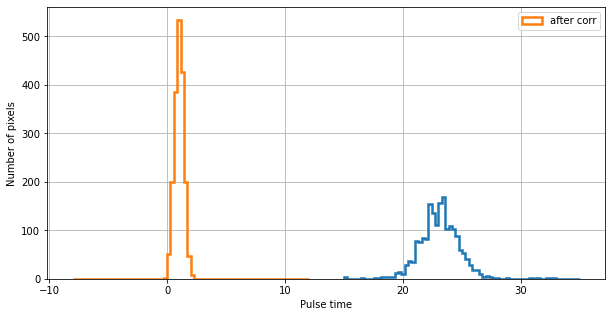

std before correction 1.67
std after correction 0.38


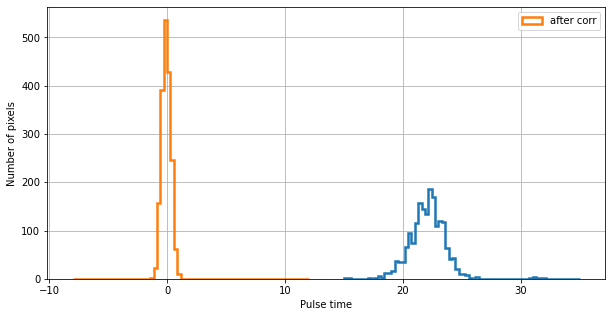

std before correction 1.51
std after correction 0.37


In [49]:
reader = LSTEventSource(
    input_url="../data/LST-1.1.Run01625.0001.fits.fz",
    max_events=15)

pulse_corr = PulseTimeCorrection(calib_file_path='../data/time_calibration.Run1625.0000.hdf5')
tel_id = 1
config = Config({
        "LSTR0Corrections": {
            "pedestal_path": None, # if baseline correction was done in EVB
            "tel_id": tel_id,
            "r1_sample_start":3,
            "r1_sample_end":39
        }
})

lst_r0 = LSTR0Corrections(config=config)
extractor = LocalPeakWindowSum(window_width=11, window_shift=4, subarray=reader.subarray)
gain = 0

for i, ev in enumerate(reader):        
    lst_r0.calibrate(ev)                  # Cut in signal to avoid cosmic events    
    if ev.r0.tel[tel_id].trigger_type == 1 and np.mean(ev.r1.tel[tel_id].waveform[:, :, :]) > 100:
        no_gain_selection = np.zeros((2,1855), dtype=np.int8)
        charge, pulse = extractor(ev.r1.tel[tel_id].waveform[:, :, :], tel_id, no_gain_selection)
        pulse_corr_array = pulse_corr.get_corr_pulse(ev, pulse)
        time_fan = pulse_corr.fan_array[0, :, 0]/2 # mean time from correction curve
        pulse_corr_array = pulse_corr_array - time_fan
        
        plt.figure(figsize=(10, 5))
        plt.hist(pulse[gain,:], bins=70, range=(15, 35), 
                 histtype='step', lw=2.5)
        plt.hist(pulse_corr_array[gain,:], bins=70, range=(-8, 12), 
                 histtype='step', lw=2.5, label="after corr")
        plt.xlabel("Pulse time")
        plt.ylabel("Number of pixels")
        plt.legend()
        plt.grid(True)
        plt.show()
        print("std before correction {:.2f}".format(np.std(pulse[gain, :])))
        print("std after correction {:.2f}".format(np.std(pulse_corr_array[gain, :])))

## Apply time correction to cosmic events 

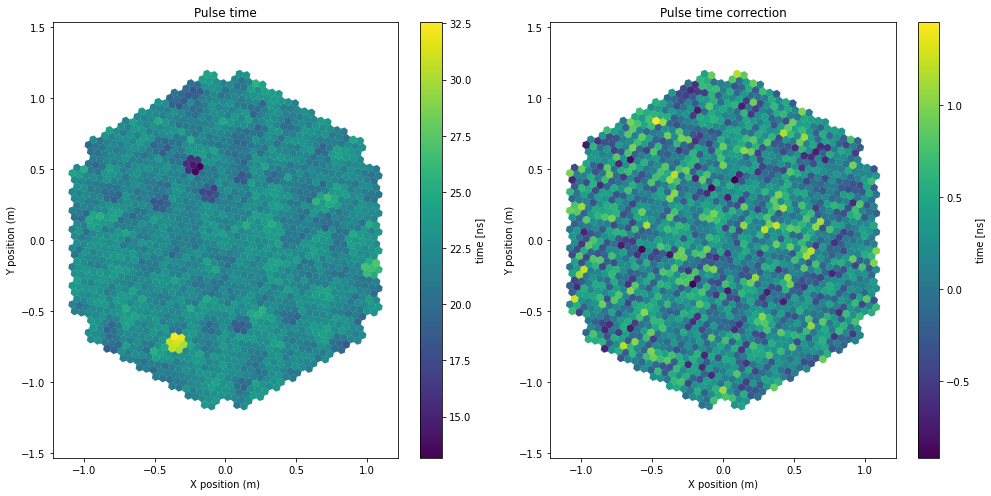

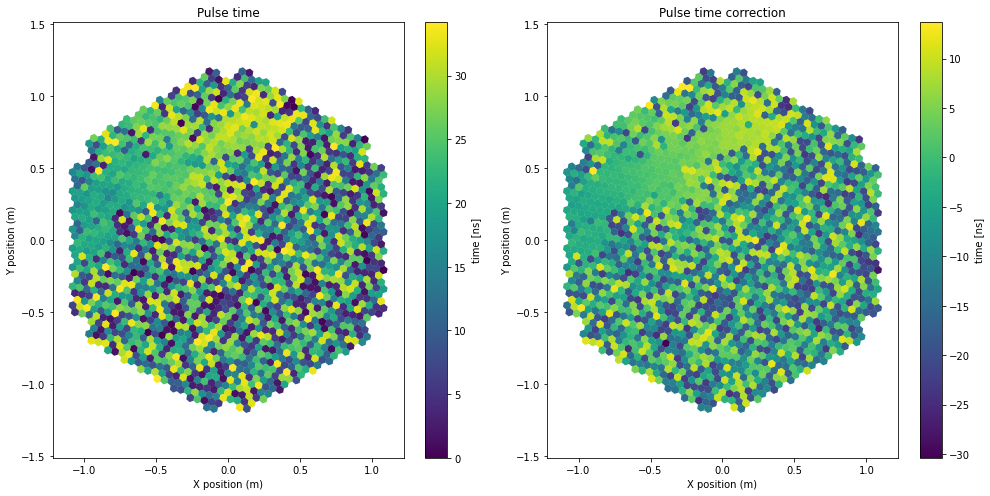

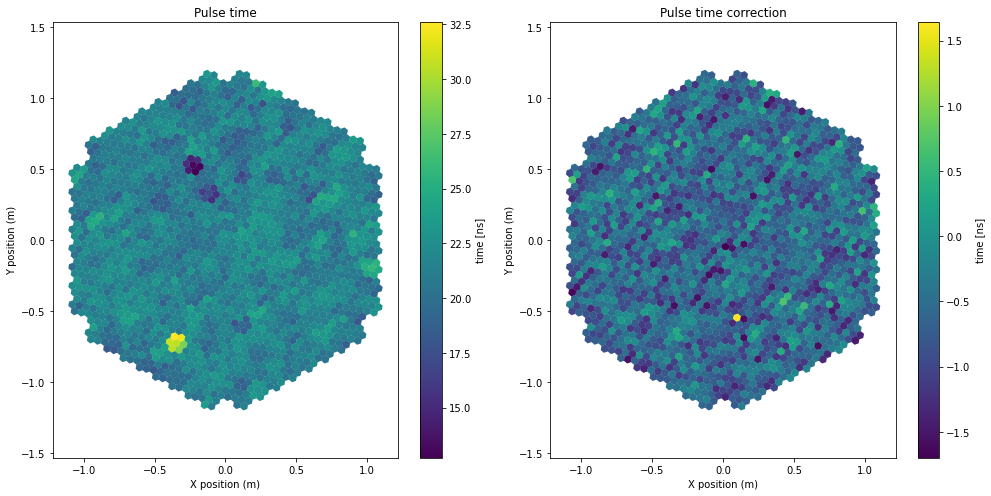

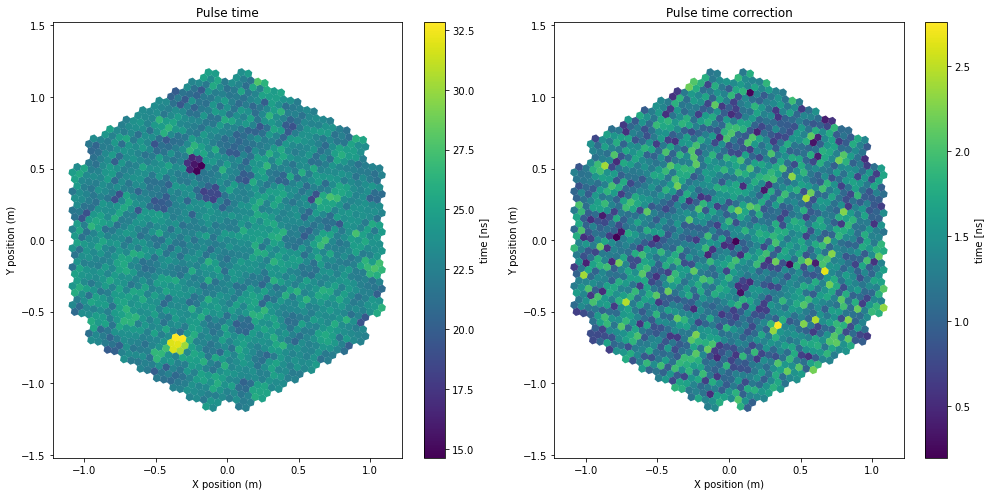

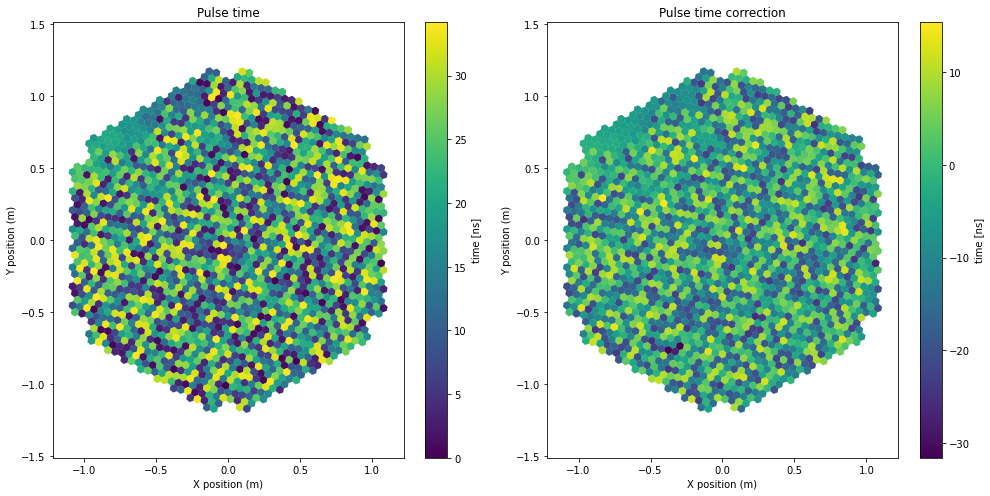

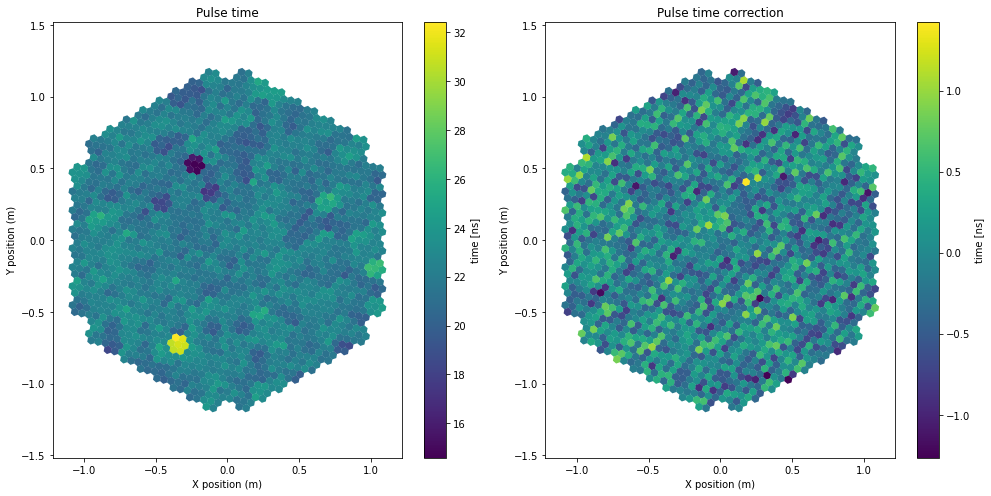

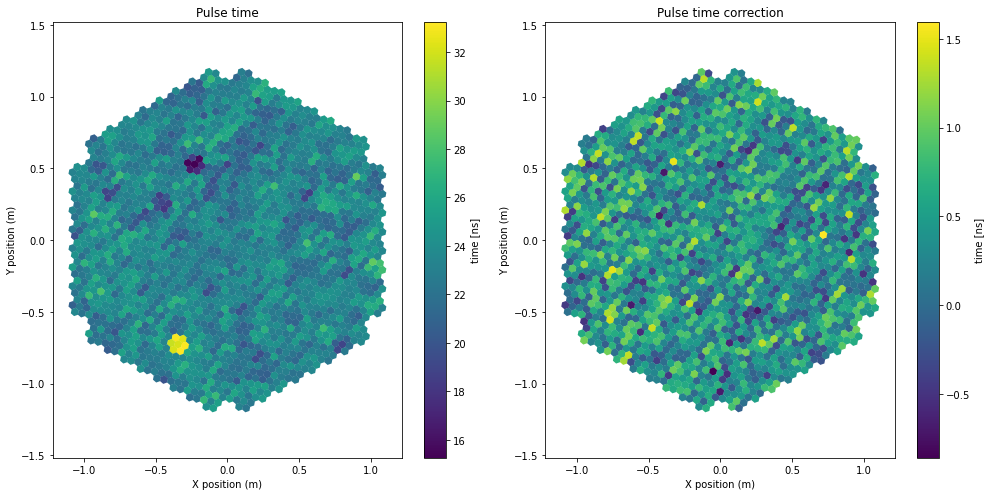

In [52]:
input_file_1 = "../data/LST-1.1.Run01627.0001.fits.fz"

reader = LSTEventSource(input_url=input_file_1, max_events=200)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": None, # For run with baseline correction online
        "offset":  400,
        "tel_id": 1,
        "r1_sample_start":3,
        "r1_sample_end":39
    }
})
tel_id = 1

lst_r0 = LSTR0Corrections(config=config_corr)

extractor = LocalPeakWindowSum(window_width=11, window_shift=4, subarray=reader.subarray)
gain = 0
geom = CameraGeometry.from_name("LSTCam", 2)
pulse_corr = PulseTimeCorrection(calib_file_path='../data/time_calibration.Run1625.0000.hdf5')

for i, ev in enumerate(reader):
    lst_r0.calibrate(ev)                       # Cut to see some signal from cosmic events  
    if ev.r0.tel[tel_id].trigger_type == 1 and np.sum(ev.r1.tel[tel_id].waveform[gain, :, :]>600) > 100:
        
        no_gain_selection = np.zeros((2,1855), dtype=np.int8)
        charge, pulse_time = extractor(ev.r1.tel[tel_id].waveform[:, :, :], tel_id, no_gain_selection)
        pulse_corr_array = pulse_corr.get_corr_pulse(ev, pulse_time)
        time_fan = pulse_corr.fan_array[0, :, 0]/2 # mean time from correction curve
        pulse_corr_array = pulse_corr_array - time_fan
           
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
        disp1 = CameraDisplay(geom, ax=ax[0])
        disp1.image = pulse_time[gain, :]
        disp1.add_colorbar(ax=ax[0], label="time [ns]")
        disp1.cmap = 'viridis'
        ax[0].set_title("Pulse time")
        
        disp2 = CameraDisplay(geom, ax=ax[1])
        disp2.image = pulse_corr_array[gain, :]
        disp2.add_colorbar(ax=ax[1], label="time [ns]")
        disp2.cmap = 'viridis'
        ax[1].set_title("Pulse time correction")
        plt.tight_layout()        
        plt.show()